In [2]:
!pip install tweepy

In [2]:
import tweepy
import pandas as pd
import numpy as np
from pprint import pprint

In [3]:
from pymongo import MongoClient

In [4]:
client = MongoClient('localhost',27017)
db = client["SMM"]
tweets_coll = db["tweets"]

In [5]:
cursor = tweets_coll.find()

In [6]:
tweets_df = pd.DataFrame(list(cursor))

In [7]:
tweets_df.columns

Index([u'_id', u'contributors', u'coordinates', u'created_at',
       u'display_text_range', u'entities', u'extended_entities',
       u'extended_tweet', u'favorite_count', u'favorited', u'filter_level',
       u'geo', u'id', u'id_str', u'in_reply_to_screen_name',
       u'in_reply_to_status_id', u'in_reply_to_status_id_str',
       u'in_reply_to_user_id', u'in_reply_to_user_id_str', u'is_quote_status',
       u'lang', u'place', u'possibly_sensitive', u'quote_count',
       u'quoted_status', u'quoted_status_id', u'quoted_status_id_str',
       u'quoted_status_permalink', u'reply_count', u'retweet_count',
       u'retweeted', u'retweeted_status', u'search_term', u'source', u'text',
       u'timestamp_ms', u'truncated', u'user'],
      dtype='object')

### We are trying to find the interaction between users based on retweets, mentions and replies

#### We take only the columns which are constant for all tweets, as the rest are variable

In [8]:
tweets_df_new = tweets_df[['_id','search_term','created_at','text']]
tweets_df_new.head()

_id search_term                      created_at  \
0  1175981513961160705   spiderman  Mon Sep 23 03:53:36 +0000 2019   
1  1175981520516861960   spiderman  Mon Sep 23 03:53:37 +0000 2019   
2  1175981553446313984   spiderman  Mon Sep 23 03:53:45 +0000 2019   
3  1175981580495417344   spiderman  Mon Sep 23 03:53:52 +0000 2019   
4  1175981629803761665   spiderman  Mon Sep 23 03:54:03 +0000 2019   

                                                text  
0  @TubeAfterDark She hangs upside down like holl...  
1  RT @thetablopodcast: This is what happens when...  
2  RT @thetablopodcast: This is what happens when...  
3  RT @Jac_Mirie: spider bicons\n________________...  
4  Rumor: Sony has an asking price of $10 billion...

In [9]:
def get_user_info(tweets_df):
    tweets_df_new["user_id"] = tweets_df.apply(lambda x:x["user"]["id_str"],axis=1)
    tweets_df_new["user_followers_count"] = tweets_df.apply(lambda x:x["user"]["followers_count"],axis=1)
    tweets_df_new["user_screen_name"] = tweets_df.apply(lambda x:x["user"]["screen_name"],axis=1)
    tweets_df_new["user_friends_count"] = tweets_df.apply(lambda x:x["user"]["friends_count"],axis=1)
    
    return tweets_df_new

In [10]:
def get_replies_info(tweets_df):
    tweets_df_new["in_reply_to_user_id"] = tweets_df.apply(lambda x:x["in_reply_to_user_id_str"] if x["in_reply_to_user_id_str"]!=None else None ,axis=1)
    tweets_df_new["in_reply_to_screen_name"] = tweets_df.apply(lambda x:x["in_reply_to_screen_name"] if x["in_reply_to_screen_name"]!=None else None ,axis=1)
    tweets_df_new["in_reply_to_status_id"] = tweets_df.apply(lambda x:x["in_reply_to_status_id_str"] if x["in_reply_to_status_id_str"]!=None else None ,axis=1)
    
    return tweets_df_new
    
    

In [11]:
def get_mention_info(tweets_df):
    tweets_df_new["user_mentions_id"] = tweets_df["entities"].apply(lambda x:map(lambda y:y["id_str"],x["user_mentions"]) if x["user_mentions"] else None)
    tweets_df_new["user_mentions_screen_name"] = tweets_df["entities"].apply(lambda x:map(lambda y:y["screen_name"],x["user_mentions"]) if x["user_mentions"] else None)
    
    return tweets_df_new

In [12]:
def get_retweets_info(tweets_df):
    tweets_df_new["retweet_screen_name"] = tweets_df["retweeted_status"].apply(lambda x: x["user"]["screen_name"] if x is not np.nan else None)
    tweets_df_new["retweet_user_id"] = tweets_df["retweeted_status"].apply(lambda x: x["user"]["id_str"] if x is not np.nan else None)

### Populating the new tweets Dataframe with the extracted values

In [13]:
get_user_info(tweets_df)
get_replies_info(tweets_df)
get_mention_info(tweets_df)
get_retweets_info(tweets_df)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

### Building the graph for all the user interactions

In [14]:
import networkx as nx
from matplotlib import pyplot as plt

In [15]:
graph = nx.Graph()

In [16]:
def get_user_interaction(row):
    interaction = set()
    user = [row["user_id"],row["user_screen_name"]]
    if user[0] == None:
        return None,[]
    else:
        if row["retweet_user_id"] != None:
            interaction.add((row["retweet_user_id"],row["retweet_screen_name"]))

        if row["in_reply_to_user_id"] != None:
            interaction.add((row["in_reply_to_user_id"],row["in_reply_to_screen_name"]))

        if row["user_mentions_id"] != None: ## Adding multiple user mentions
            for i in range(len(row["user_mentions_id"])):
                interaction.add((row["user_mentions_id"][i],row["user_mentions_screen_name"][i]))
    return user,interaction
    

In [17]:
for i,row in tweets_df_new.iterrows():
    user,interactions = get_user_interaction(row)
    if len(interactions)>0:
        for interaction in interactions:
            graph.add_edge(str(user[0]),str(interaction[0]))
            graph.node[str(user[0])]["name"] = str(user[1])
            graph.node[str(interaction[0])]["name"] = str(interaction[1])
            
    

In [18]:
plt.figure(figsize = (100,100))
nx.draw(graph,pos=nx.spring_layout(graph))

###### As we can see, the graph above is too big and has many disconnected components. Hence We try to extract few of the largest connected components.

In [19]:
graph.number_of_nodes()

3994

In [21]:
def visualize_top_subgraphs(num_sub_graphs):
    sub_graphs = sorted(nx.connected_component_subgraphs(graph), key=len, reverse=True)[:num_sub_graphs]
    
    num_rows = (num_sub_graphs//2) if num_sub_graphs%2==0 else (num_sub_graphs//2+1)
    plt.figure(figsize = (100,100))
#     print(num_rows)
    num_cols = 2
    for i,gf in enumerate(sub_graphs):
        plt.subplot(num_rows,num_cols,i+1)
        pos = nx.spring_layout(gf)
        nx.draw(gf,pos=pos)
        node_labels = nx.get_node_attributes(gf,'name')
        nx.draw_networkx_labels(gf, pos=pos, labels = node_labels)

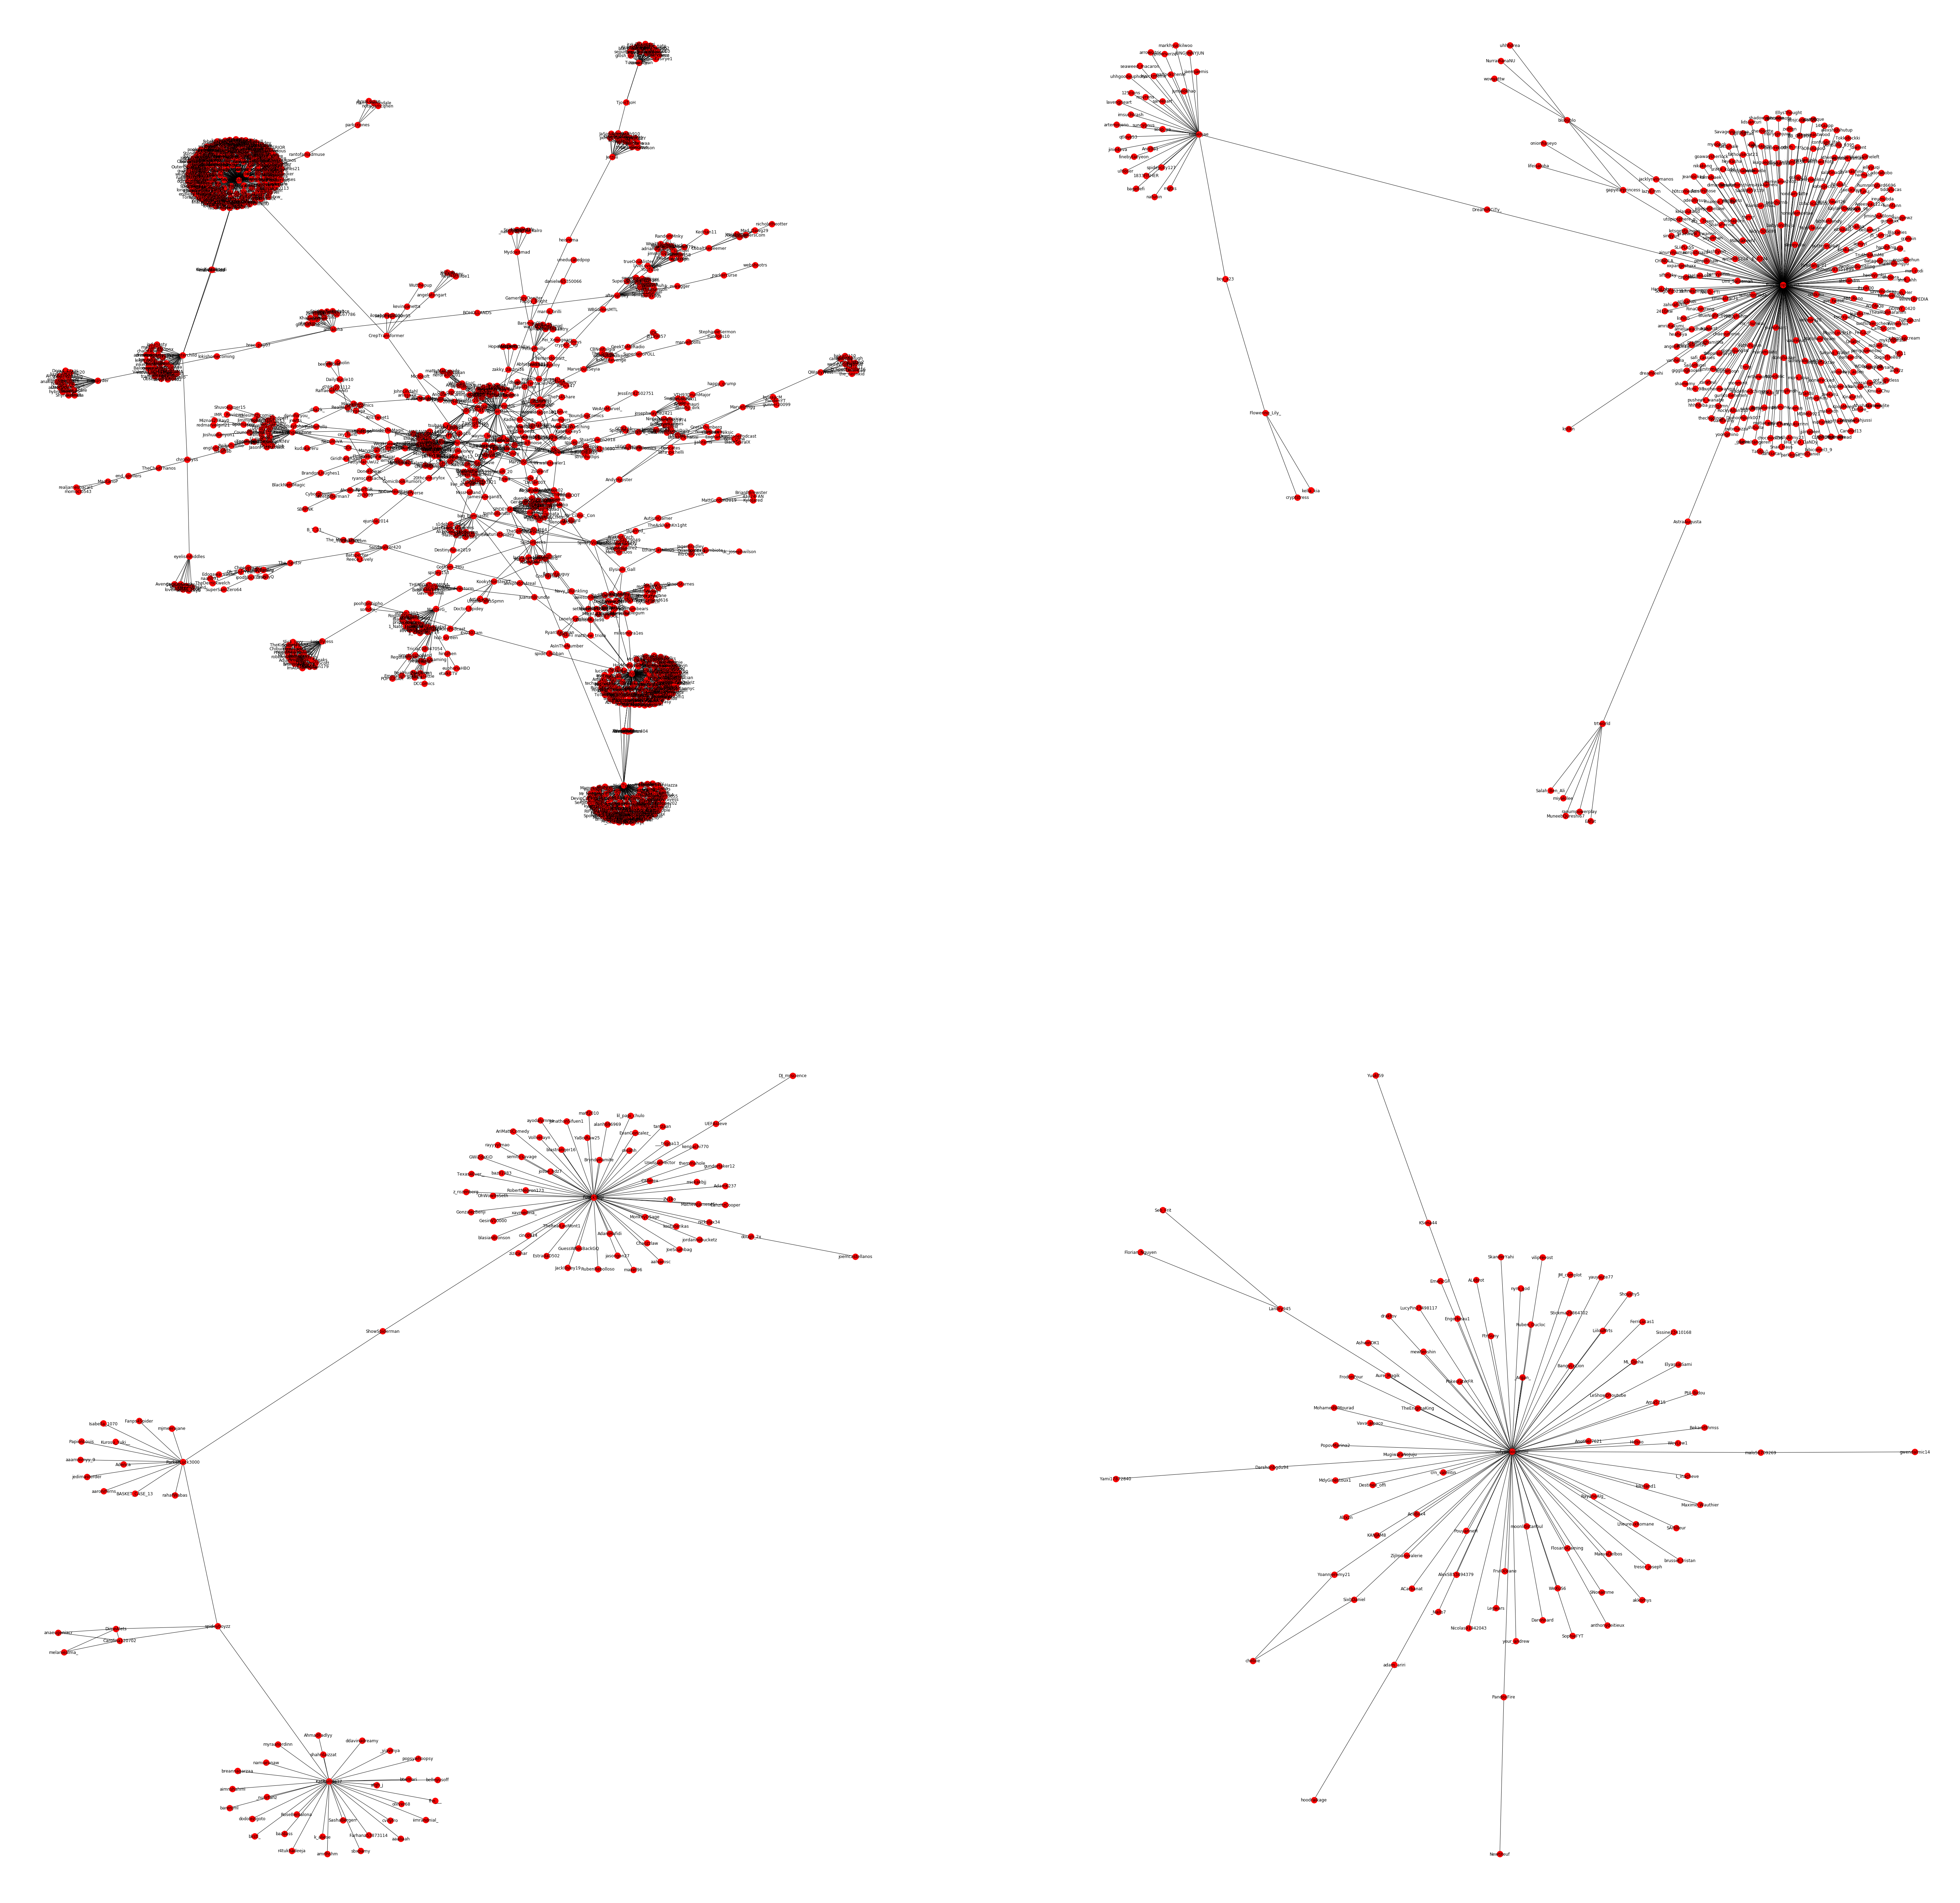

In [23]:
visualize_top_subgraphs(4)

In [26]:
graph_centrality = nx.degree_centrality(graph)
max_de = sorted(graph_centrality.items(), key=lambda x:x[1],reverse=True)

In [32]:
for i in range(10):
    print(graph.node[max_de[i][0]])

{'name': 'thetablopodcast'}
{'name': 'lovingbarnes'}
{'name': 'ChallengeAnim'}
{'name': 'NickTyson'}
{'name': 'sofyanboudouni'}
{'name': 'FuuckYugi'}
{'name': 'VolkorNSFW'}
{'name': 'pewposterous'}
{'name': 'TemptyVA'}
{'name': 'SpiderMan'}


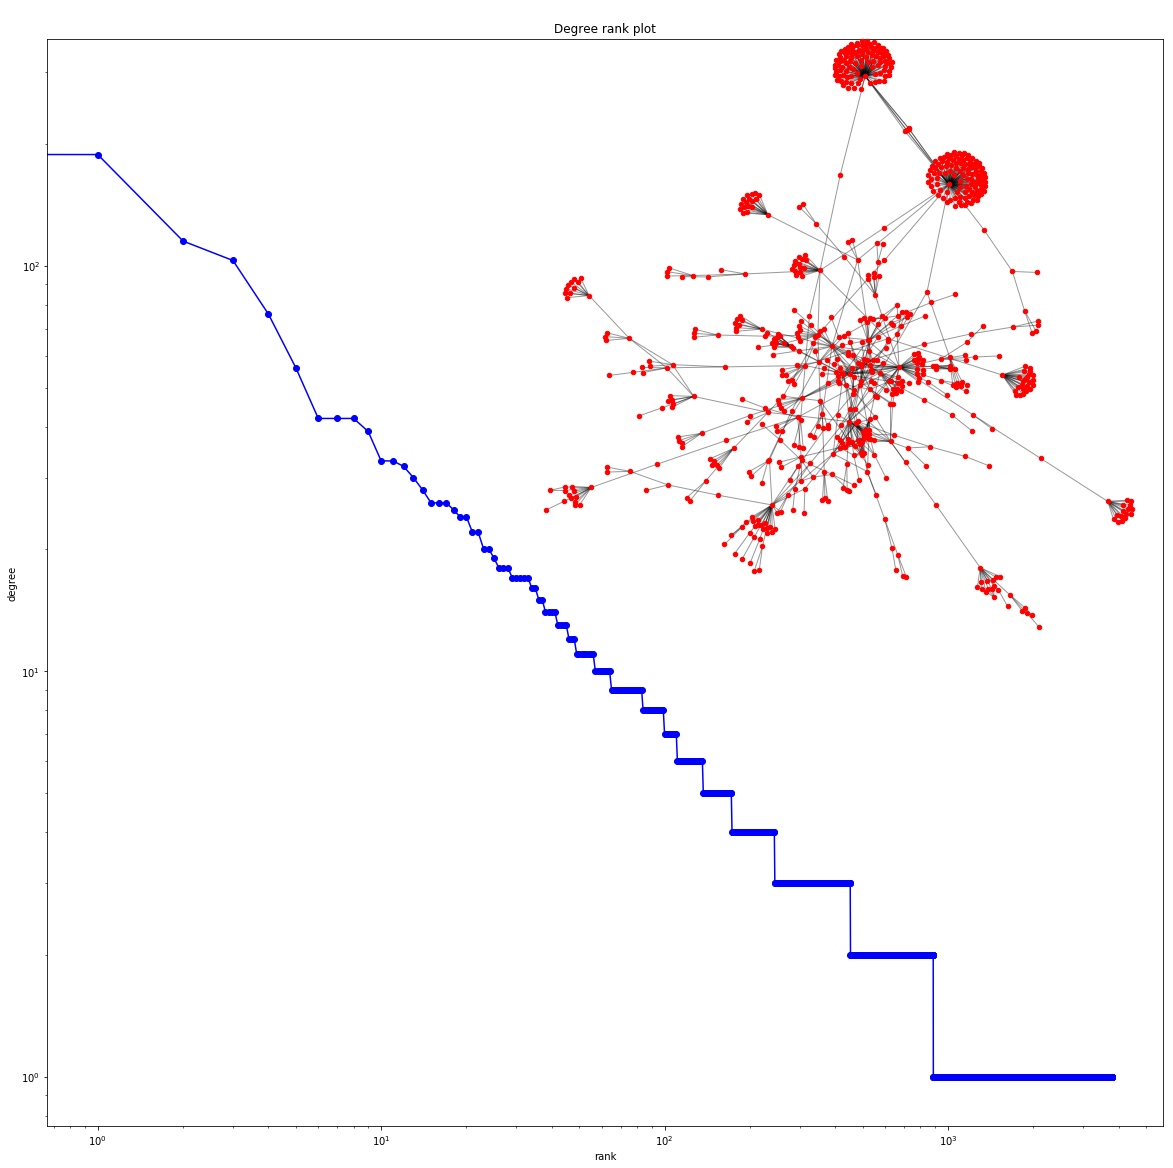

In [225]:

plt.figure(figsize = (20,20))
degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)
# print "Degree sequence", degree_sequence
dmax = max(degree_sequence)

plt.loglog(degree_sequence, 'b-', marker='o')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

# draw graph in inset
plt.axes([0.45, 0.45, 0.45, 0.45])
Gcc = sorted(nx.connected_component_subgraphs(graph), key=len, reverse=True)[0]
pos = nx.spring_layout(Gcc)
plt.axis('off')
nx.draw_networkx_nodes(Gcc, pos, node_size=20)
nx.draw_networkx_edges(Gcc, pos, alpha=0.4)

plt.show()